# **Facial Expression Recognition**

**This Notebook releate to build a CNN model to acurately categorize 7 type of human facial expression
which are [sad, happy, disgust, angry, neutral, fear, surprise]**


**Importing Modules**

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
import scipy
%matplotlib inline

from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
# from livelossplot import PlotLossesTensorFlowKeras
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.0


**Load and Explore the Dataset**

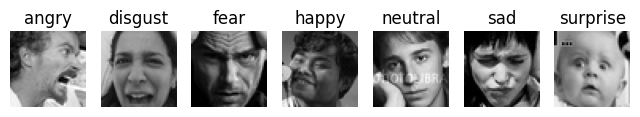

In [2]:
i = 1
plt.figure(figsize=(8,8))
for expression in os.listdir(os.curdir + '/data/test/'):
    img = load_img((os.curdir + '/data/test/' + expression +'/'+ os.listdir(os.curdir + '/data/test/' + expression)[1]))
    # img = load_img((os.curdir + '/data/test/' + expression +'/'+ os.curdir + '/data/test/' + expression)[1])
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
    
plt.show()

In [3]:
#check the amount of data in each folder in training dataset
for expression in os.listdir(os.curdir + '/data/train/'):
    print(expression, "folder contains\t\t", len(os.listdir(os.curdir + '/data/train/'+expression)), "images")

angry folder contains		 3995 images
disgust folder contains		 436 images
fear folder contains		 4097 images
happy folder contains		 7215 images
neutral folder contains		 4965 images
sad folder contains		 4830 images
surprise folder contains		 3171 images


In [4]:
#check the amount of data in each folder in testing dataset
for expression in os.listdir(os.curdir + '/data/test/'):
    print(expression, "folder contains\t\t", len(os.listdir(os.curdir + '/data/test/'+expression)), "images")

angry folder contains		 958 images
disgust folder contains		 111 images
fear folder contains		 1024 images
happy folder contains		 1774 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
surprise folder contains		 831 images


**Augmentation and Preprocessing**

In [5]:
# Data Augmentation

datagen_train = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

train_generator = datagen_train.flow_from_directory(os.curdir + '/data/train/',
                                                batch_size = 64,
                                                target_size=(48, 48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

datagen_test = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

test_generator = datagen_test.flow_from_directory(os.curdir + '/data/test/',
                                                batch_size = 64,
                                                target_size=(48, 48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Build the CNN Model**

In [6]:
model = tf.keras.models.Sequential()   

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01) ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0005, decay=1e-6),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

**Training and Saving the Model**

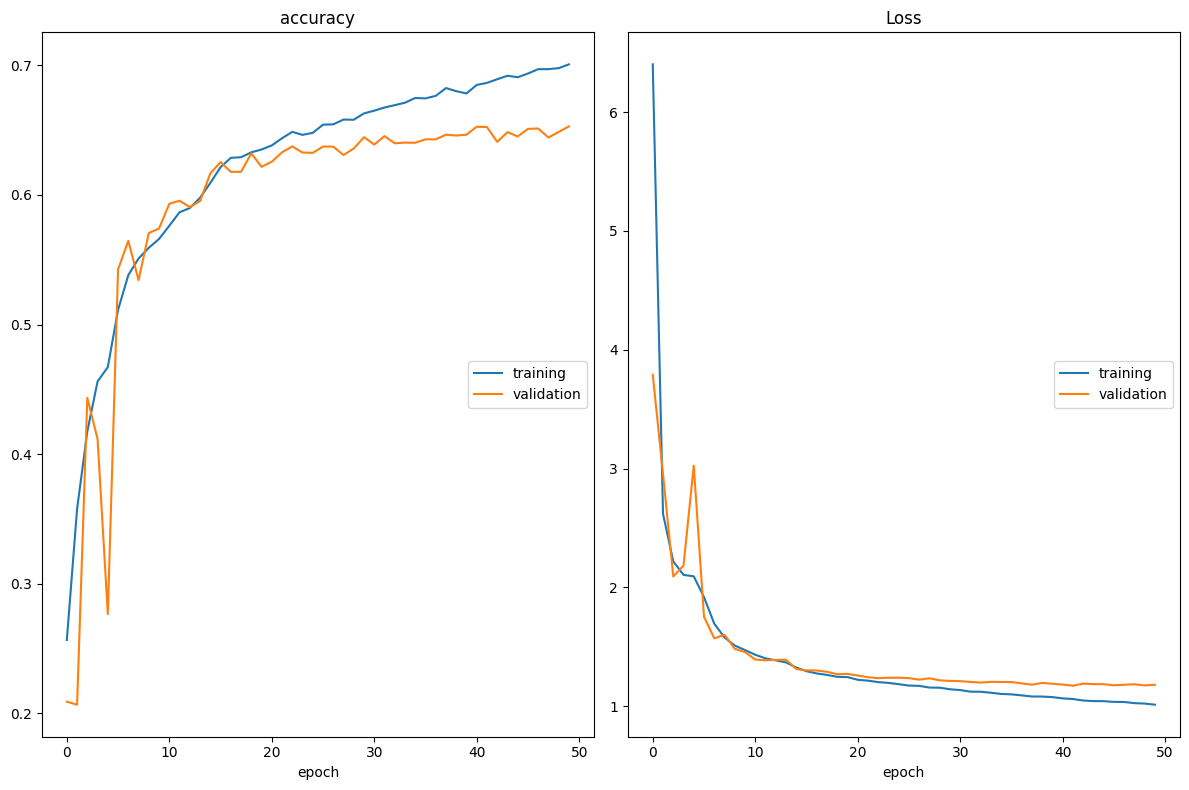

accuracy
	training         	 (min:    0.257, max:    0.701, cur:    0.701)
	validation       	 (min:    0.207, max:    0.653, cur:    0.653)
Loss
	training         	 (min:    1.014, max:    6.401, cur:    1.014)
	validation       	 (min:    1.173, max:    3.790, cur:    1.181)

Epoch 50: saving model to model_weights.h5
448/448 [==============================] - 1088s 2s/step - loss: 1.0136 - accuracy: 0.7008 - val_loss: 1.1810 - val_accuracy: 0.6530 - lr: 1.0000e-05


In [7]:
epochs = 50
steps_per_epoch = train_generator.n/train_generator.batch_size
testing_steps = test_generator.n/test_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor="val_accuracy", save_weights_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.1, patience = 2, min_lr=0.00001, model='auto')

callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=testing_steps,
    callbacks=callbacks
)